In [18]:
using LinearAlgebra
using TrajectoryOptimization
using Plots
pyplot()

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1273


Plots.PyPlotBackend()

In [2]:
#Pauli spin matrices
i2 = [0 -1; 1 0] #2x2 unit imaginary matrix
Sx = [zeros(2,2) I; I zeros(2,2)]
Sy = [zeros(2,2) -i2; i2 zeros(2,2)]
Sz = [I zeros(2,2); zeros(2,2) -I]
iSx = [zeros(2,2) i2; i2 zeros(2,2)]
iSy = [zeros(2,2) I; -I zeros(2,2)]
iSz = [i2 zeros(2,2); zeros(2,2) -i2];

In [3]:
function qubit_dynamics!(ẋ,x,ü)
      u̇ = x[5]
      u = x[6]
      ẋ .= [(-iSx - u.*iSz)*x[1:4]; ü; u̇; u]
end

qubit_dynamics! (generic function with 1 method)

In [4]:
n = 7 #state dimension
m = 1 #inut dimension
model = Model(qubit_dynamics!,n,m)
model_d = rk4(model);

In [5]:
dt = 0.01 #time step
N = 101 #number of knot points

x0 = [1.0, 0, 0, 0, 0, 0, 0] #initial state
xf = [1/sqrt(2), 0, 1/sqrt(2), 0, 0, 0, 0] #desired final state

u0 = [randn(m) for k = 1:N-1]; #random initial guess for control inputs

#Set up quadratic objective function
Q = Diagonal([1e-3, 1e-3, 1e-3, 1e-3, 1, 1, 1e-3])
R = 1.0*Diagonal(I,m)
Qf = 1.0*Diagonal(I,n)
obj = LQRObjective(Q,R,Qf,xf,N);

In [6]:
#Set up input constriants
goal = goal_constraint(xf) # terminal constraint
constraints = Constraints(N) # define constraints at each time step
constraints[N] += goal;

In [7]:
#Set up and solve traj. opt. problem
prob = Problem(model_d, obj, constraints=constraints, x0=x0, xf=xf, N=N, dt=dt)
initial_controls!(prob, u0) #random guess for initial controls
solver = solve!(prob, ALTROSolverOptions{Float64}());

┌ Info: Augmented Lagrangian solve...
└ @ TrajectoryOptimization /Users/zac/.julia/dev/TrajectoryOptimization/src/solvers/altro/altro_methods.jl:25


In [8]:
X = fill(Float64[], N)
U = zeros(N)
U̇ = zeros(N)
for k = 1:N
      X[k] = prob.X[k][1:4]
      U[k] = prob.X[k][6]
      U̇[k] = prob.X[k][5]
end

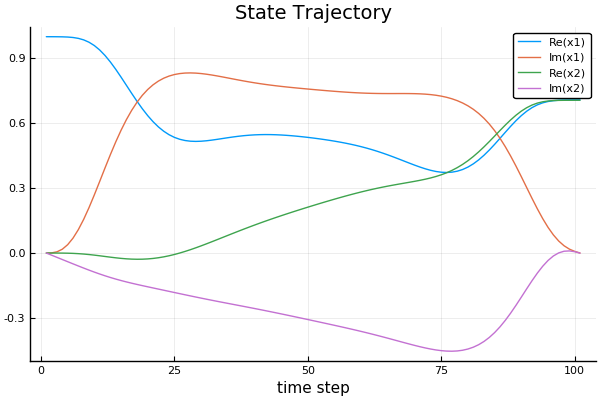

In [19]:
plot(X,xlabel="time step",title="State Trajectory",label=["Re(x1)" "Im(x1)" "Re(x2)" "Im(x2)"])

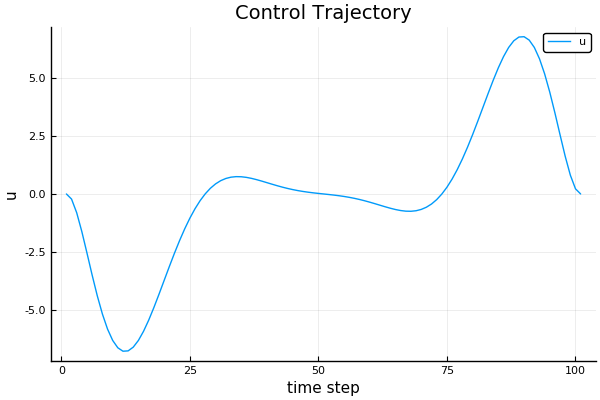

In [20]:
plot(U,xlabel="time step",ylabel="u",title="Control Trajectory",label="u")

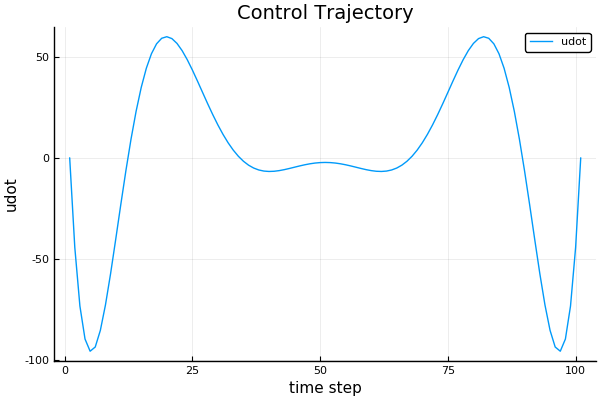

In [21]:
plot(U̇,xlabel="time step",ylabel="udot",title="Control Trajectory",label="udot")

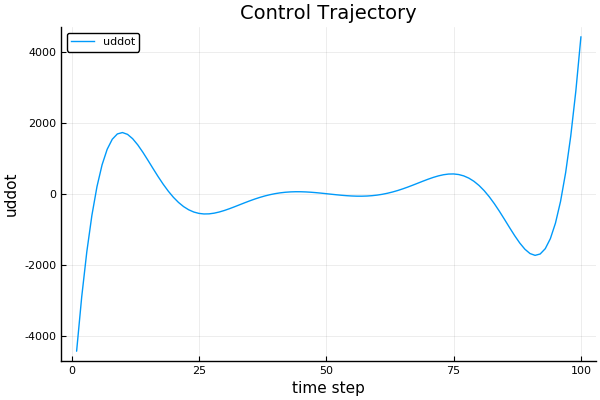

In [22]:
plot(prob.U,xlabel="time step",ylabel="uddot",title="Control Trajectory",label="uddot")